In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


In [2]:
datadir = '/data/Sberbank/'

In [3]:
train = pd.read_csv(datadir+'train.csv', parse_dates=['timestamp'])

# truncate the extreme values in price_doc #
ulimit = np.percentile(train.price_doc.values, 99)
llimit = np.percentile(train.price_doc.values, 1)
train['price_doc'].ix[train['price_doc'] > ulimit] = ulimit
train['price_doc'].ix[train['price_doc'] < llimit] = llimit

y =np.log1p(train['price_doc'])
# y = train['price_doc']

train.drop(['price_doc','id', 'timestamp'], axis=1, inplace=True)
# train = feature_eng(train)

for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values))
        train[c] = lbl.transform(list(train[c].values))
        # x_train.drop(c,axis=1,inplace=True)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
train.shape

(30471, 289)

In [5]:
feat = train.columns

# Correlation 

 

In [6]:
colmatrix = train.corr()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


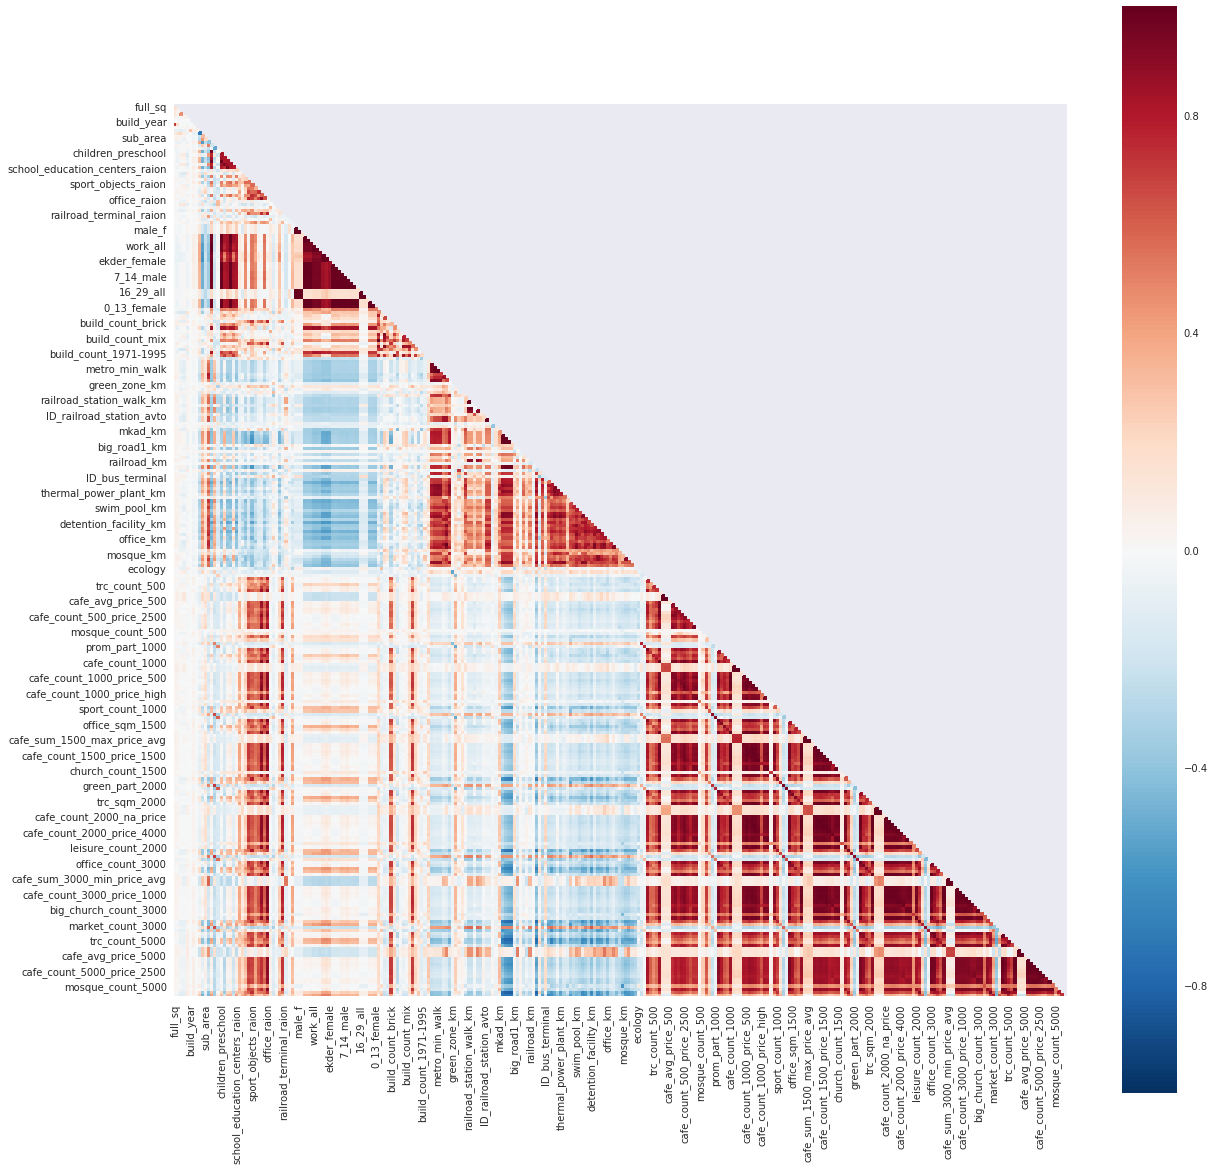

In [7]:
plt.subplots(figsize=(20, 20))
mask = np.zeros_like(colmatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(colmatrix, mask=mask,  square=True, xticklabels=5, yticklabels=5)

The correlation plot  indicates a high degree of correlation in terms of number of features and its magnitude. This high degree of correlation motivated us to do a Principal Component Analysis of the data.

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
train.fillna(0, inplace = True)
scaler = StandardScaler()
xtrain = scaler.fit_transform(train)

In [9]:
pca = PCA(n_components = 150)
pca.fit(xtrain)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


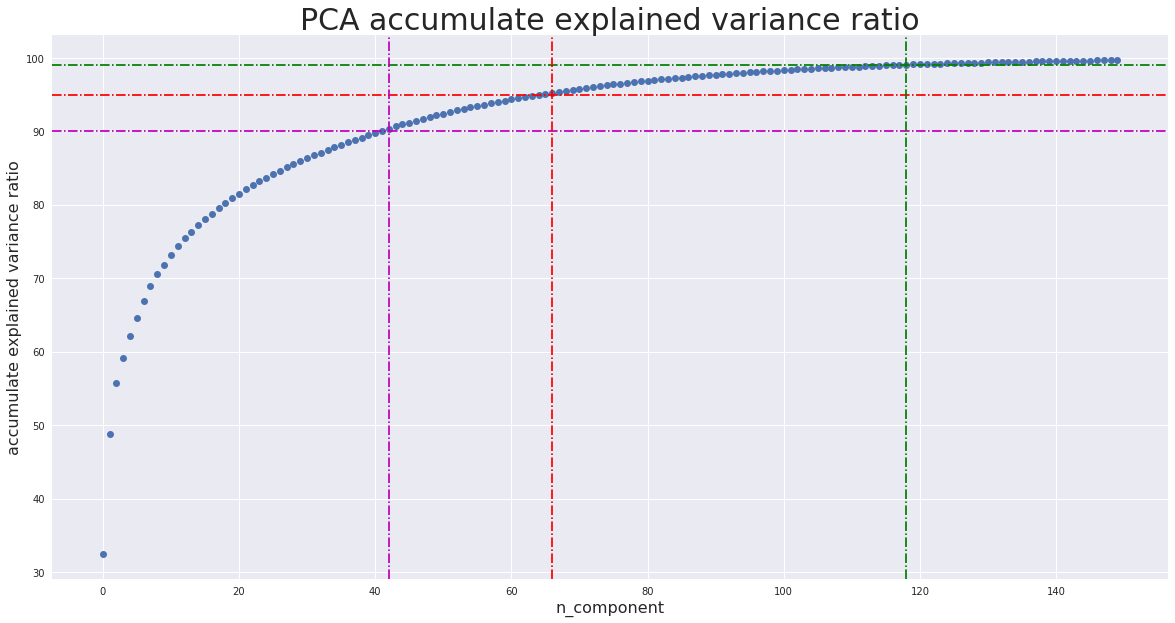

In [10]:
import numpy 
tot = numpy.cumsum(pca.explained_variance_ratio_)*100
plt.figure(figsize = (20,10))
plt.plot(tot,'o')
plt.axhline(y=95, color='r', linestyle = '-.')
plt.axhline(y=90, color='m', linestyle = '-.')
plt.axhline(y=99 ,color='g',linestyle = '-.')
plt.axvline(x=42, color='m', linestyle = '-.')
plt.axvline(x=66, color='r', linestyle = '-.')
plt.axvline(x=118, color='g', linestyle = '-.')
plt.title('PCA accumulate explained variance ratio', fontsize = 30)
plt.xlabel('n_component', fontsize = 16)
plt.ylabel('accumulate explained variance ratio', fontsize = 16)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


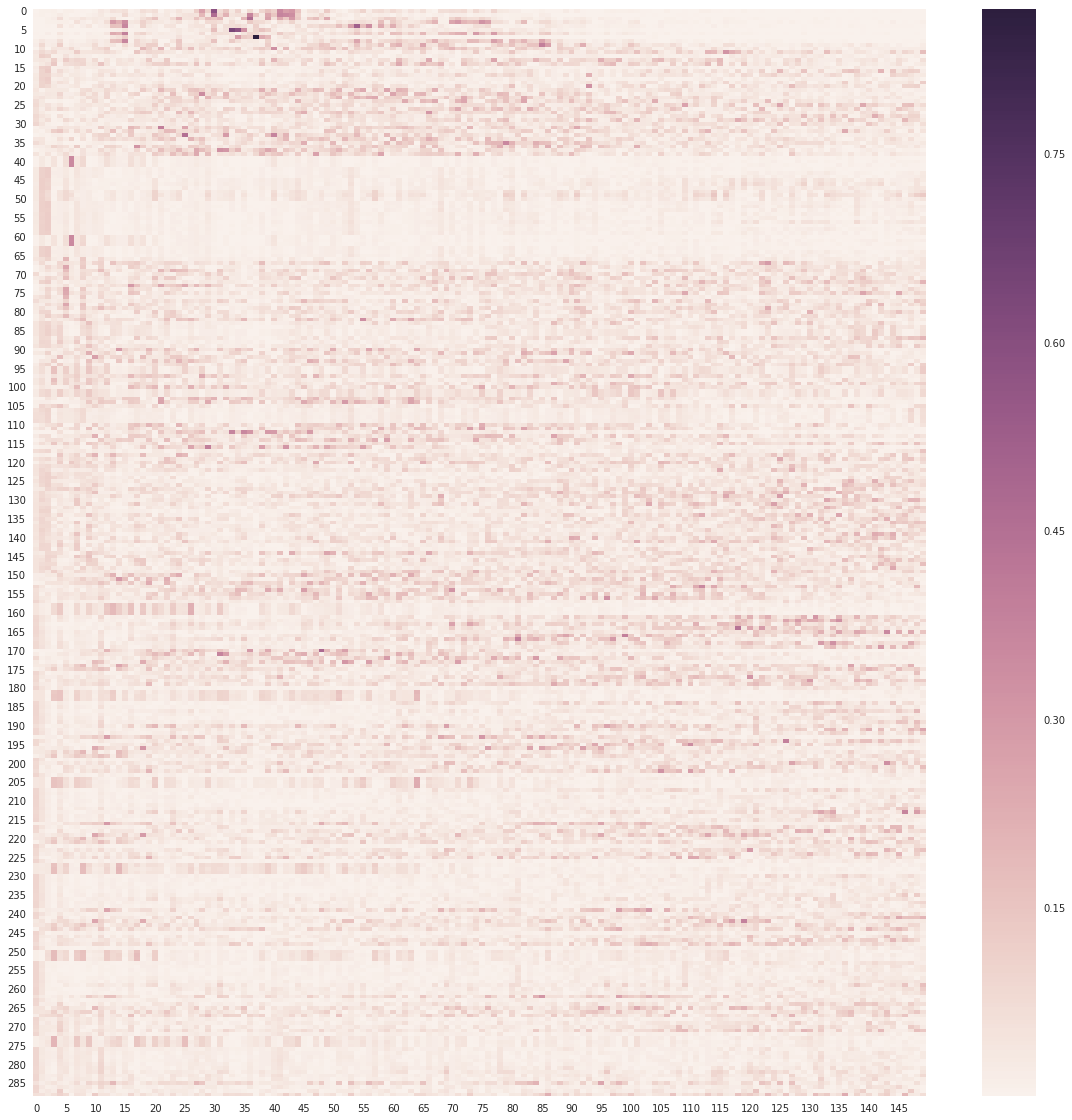

In [11]:
plt.figure(figsize = (20,20))
sns.heatmap(np.abs(pca.components_).T,xticklabels=5, yticklabels=5)

In [12]:
import xgboost as xgb
params = {
        'eta': 0.05,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'silent':1
    }


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
d_train = xgb.DMatrix(xtrain, label=y)
cv_output = xgb.cv(params, d_train, num_boost_round=1000, early_stopping_rounds=50, nfold=5, verbose_eval=50,
                           show_stdv=False)
cv_output.tail(1)

[0]	train-rmse:14.3638	test-rmse:14.3639
[50]	train-rmse:1.19846	test-rmse:1.20269
[100]	train-rmse:0.441738	test-rmse:0.467621
[150]	train-rmse:0.418426	test-rmse:0.456479
[200]	train-rmse:0.4075	test-rmse:0.455775
[250]	train-rmse:0.397944	test-rmse:0.455697
[300]	train-rmse:0.389218	test-rmse:0.455897


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
263,0.455604,0.002467,0.395478,0.001188


In [14]:
d_train = xgb.DMatrix(pca.transform(xtrain), label=y)
cv_output = xgb.cv(params, d_train, num_boost_round=1000, early_stopping_rounds=50, nfold=5, verbose_eval=50,
                           show_stdv=False)
cv_output.tail(1)

[0]	train-rmse:14.3639	test-rmse:14.364
[50]	train-rmse:1.21312	test-rmse:1.21997
[100]	train-rmse:0.458088	test-rmse:0.492006
[150]	train-rmse:0.424411	test-rmse:0.476314
[200]	train-rmse:0.406497	test-rmse:0.472827
[250]	train-rmse:0.391925	test-rmse:0.471172
[300]	train-rmse:0.379809	test-rmse:0.470878
[350]	train-rmse:0.368403	test-rmse:0.470914


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
316,0.470811,0.003783,0.376062,0.001306


The features extracted from PCA doesn't improve the xbg results

# Correlations with target varible

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


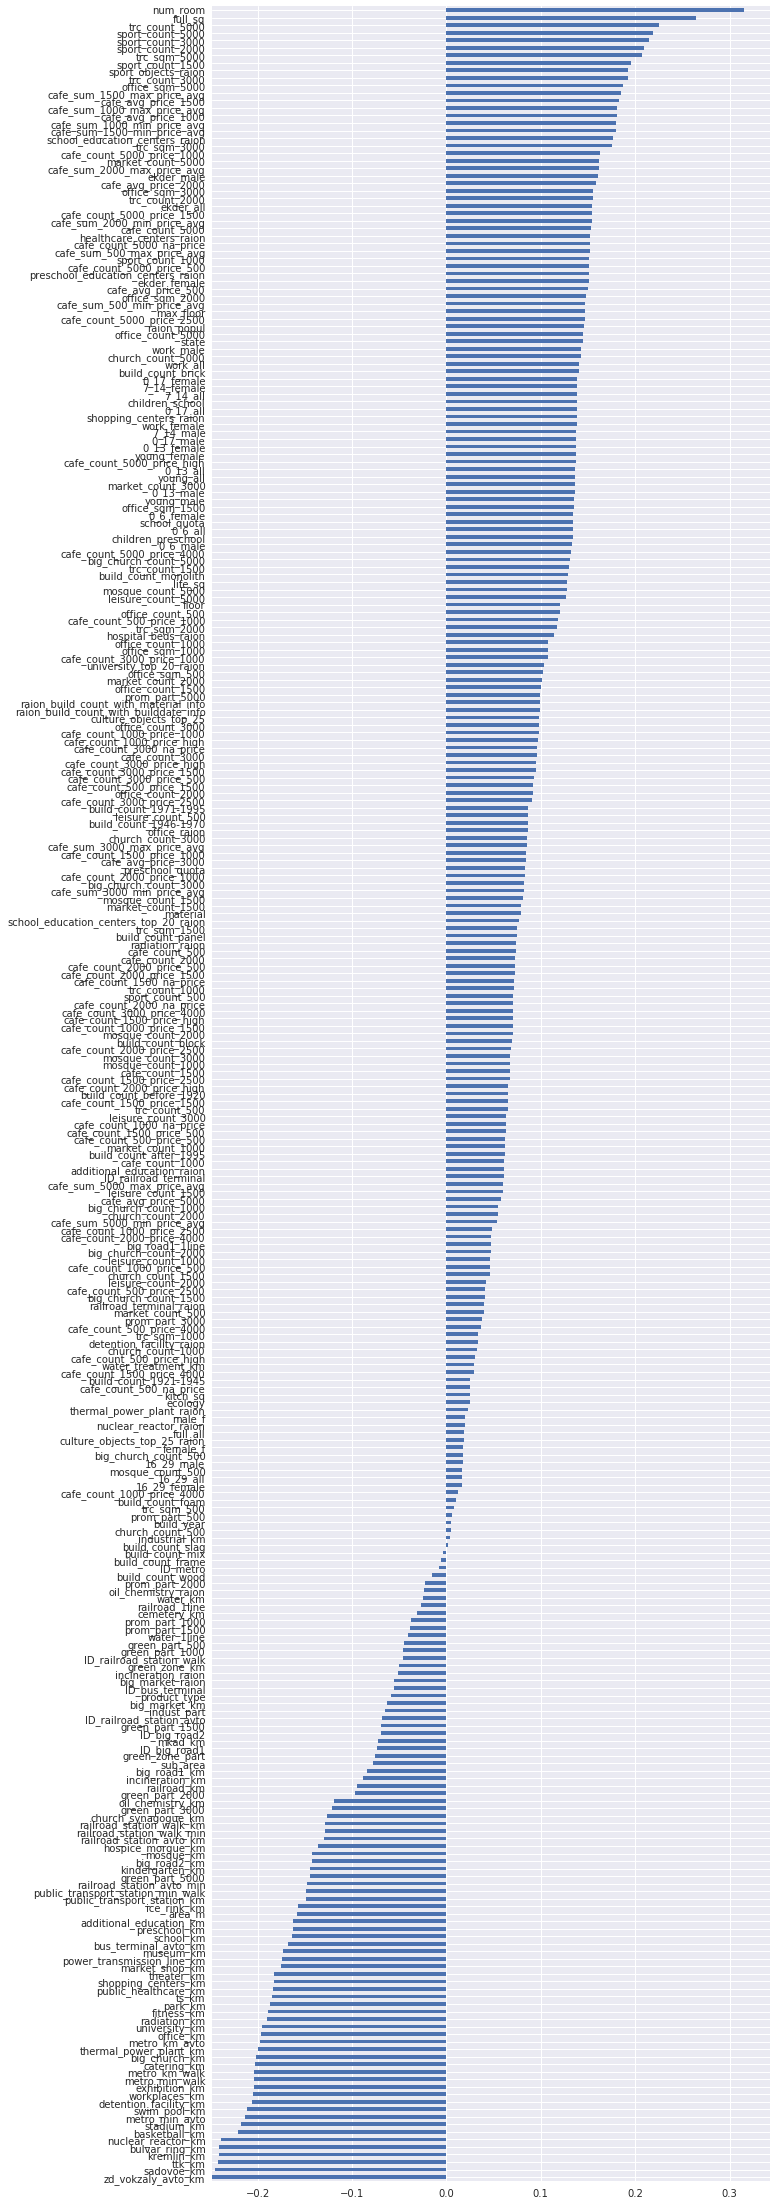

In [15]:
plt.figure(figsize =(10,40))

df = train.corrwith(y).sort_values()
df.plot.barh()

In [16]:
# training with all features
d_train = xgb.DMatrix(train, label=y)
cv_output = xgb.cv(params, d_train, num_boost_round=1000, early_stopping_rounds=50, nfold=5, verbose_eval=50,
                           show_stdv=False)
cv_output.tail(1)

[0]	train-rmse:14.3638	test-rmse:14.3639
[50]	train-rmse:1.19846	test-rmse:1.2027
[100]	train-rmse:0.441622	test-rmse:0.467627
[150]	train-rmse:0.418461	test-rmse:0.456747
[200]	train-rmse:0.4074	test-rmse:0.456062
[250]	train-rmse:0.397703	test-rmse:0.45601
[300]	train-rmse:0.388769	test-rmse:0.456244


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
254,0.455939,0.002535,0.396875,0.001151


In [17]:
# abs(correlation) > 0.1
feats = list(df[np.abs(df)>0.1].index)
d_train = xgb.DMatrix(train[feats], label=y)
cv_output = xgb.cv(params, d_train, num_boost_round=1000, early_stopping_rounds=50, nfold=5, verbose_eval=50,
                           show_stdv=False)
cv_output.tail(1)

[0]	train-rmse:14.3639	test-rmse:14.3639
[50]	train-rmse:1.19948	test-rmse:1.20369
[100]	train-rmse:0.446528	test-rmse:0.469993
[150]	train-rmse:0.424924	test-rmse:0.459398
[200]	train-rmse:0.413942	test-rmse:0.458062
[250]	train-rmse:0.404506	test-rmse:0.457841
[300]	train-rmse:0.396151	test-rmse:0.457549
[350]	train-rmse:0.388161	test-rmse:0.45784


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
306,0.457455,0.003093,0.395088,0.000568


In [18]:
# abs(correlation) > 0.05
feats = list(df[np.abs(df)>0.05].index)
d_train = xgb.DMatrix(train[feats], label=y)
cv_output = xgb.cv(params, d_train, num_boost_round=1000, early_stopping_rounds=50, nfold=5, verbose_eval=50,
                           show_stdv=False)
cv_output.tail(1)

[0]	train-rmse:14.3638	test-rmse:14.3638
[50]	train-rmse:1.19887	test-rmse:1.20343
[100]	train-rmse:0.443266	test-rmse:0.469066
[150]	train-rmse:0.420737	test-rmse:0.458029
[200]	train-rmse:0.40986	test-rmse:0.457106
[250]	train-rmse:0.400482	test-rmse:0.45712


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
237,0.456974,0.002346,0.402914,0.000457


In [19]:
# correlation > 0.05
feats = list(df[(df)>0.05].index)
print(len(feats))
d_train = xgb.DMatrix(train[feats], label=y)
cv_output = xgb.cv(params, d_train, num_boost_round=1000, early_stopping_rounds=50, nfold=5, verbose_eval=50,
                           show_stdv=False)
cv_output.tail(1)

162
[0]	train-rmse:14.3638	test-rmse:14.3639
[50]	train-rmse:1.20012	test-rmse:1.20367
[100]	train-rmse:0.450517	test-rmse:0.470739
[150]	train-rmse:0.430153	test-rmse:0.460193
[200]	train-rmse:0.420308	test-rmse:0.458851
[250]	train-rmse:0.411333	test-rmse:0.458653
[300]	train-rmse:0.403458	test-rmse:0.458484


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
288,0.458424,0.002891,0.405225,0.001643


In [20]:
# correlation > 0.0
feats = list(df[(df)>0.0].index)
print(len(feats))
d_train = xgb.DMatrix(train[feats], label=y)
cv_output = xgb.cv(params, d_train, num_boost_round=1000, early_stopping_rounds=50, nfold=5, verbose_eval=50,
                           show_stdv=False)
cv_output.tail(1)

205
[0]	train-rmse:14.3639	test-rmse:14.3639
[50]	train-rmse:1.20005	test-rmse:1.20337
[100]	train-rmse:0.448011	test-rmse:0.469493
[150]	train-rmse:0.426656	test-rmse:0.458294
[200]	train-rmse:0.416182	test-rmse:0.457192
[250]	train-rmse:0.407097	test-rmse:0.456812
[300]	train-rmse:0.39901	test-rmse:0.456795


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
267,0.456782,0.002953,0.404517,0.001258


In [21]:
# correlation < 0.0

feats = list(df[(df)<0.0].index)
print(len(feats))
d_train = xgb.DMatrix(train[feats], label=y)
cv_output = xgb.cv(params, d_train, num_boost_round=1000, early_stopping_rounds=50, nfold=5, verbose_eval=50,
                           show_stdv=False)
cv_output.tail(1)

84
[0]	train-rmse:14.3639	test-rmse:14.3639
[50]	train-rmse:1.22712	test-rmse:1.23104
[100]	train-rmse:0.514196	test-rmse:0.534347
[150]	train-rmse:0.494673	test-rmse:0.524397
[200]	train-rmse:0.484621	test-rmse:0.523421
[250]	train-rmse:0.475977	test-rmse:0.523181
[300]	train-rmse:0.468102	test-rmse:0.523071


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
272,0.522942,0.005777,0.472341,0.001077


In [22]:
# correlation > -0.05

feats = list(df[(df)>-0.05].index)
print(len(feats))
d_train = xgb.DMatrix(train[feats], label=y)
cv_output = xgb.cv(params, d_train, num_boost_round=1000, early_stopping_rounds=50, nfold=5, verbose_eval=50,
                           show_stdv=False)
cv_output.tail(1)

220
[0]	train-rmse:14.3638	test-rmse:14.3639
[50]	train-rmse:1.19971	test-rmse:1.20354
[100]	train-rmse:0.447472	test-rmse:0.469555
[150]	train-rmse:0.425446	test-rmse:0.458322
[200]	train-rmse:0.414374	test-rmse:0.457279
[250]	train-rmse:0.404876	test-rmse:0.457052
[300]	train-rmse:0.396289	test-rmse:0.457358


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
258,0.457001,0.002177,0.403328,0.000923


Features selection from correlation doesnot work well!

# Collinear Analysis --- VIF

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]
        print(vif)

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[variables]

In [24]:
# It tooks days to run, 
#     calculate_vif_(train)

In [25]:
# the feats remained after running "calculate_vif_(train)"
feats = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year',
       'num_room', 'kitch_sq', 'state', 'product_type', 'indust_part',
       'school_education_centers_top_20_raion', 'hospital_beds_raion',
       'healthcare_centers_raion', 'university_top_20_raion',
       'additional_education_raion', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
       'female_f', 'build_count_block', 'build_count_frame', 
       'build_count_monolith', 'build_count_foam', 'build_count_slag',
       'build_count_before_1920', 'build_count_1971-1995', 'ID_metro',
       'park_km', 'green_zone_km', 'ID_railroad_station_avto',
       'public_transport_station_min_walk', 'water_km', 'water_1line',
       'ID_big_road1', 'big_road1_1line', 'ID_big_road2', 'railroad_km',
       'railroad_1line', 'ID_railroad_terminal', 'catering_km',
       'green_part_500', 'prom_part_500', 'office_sqm_500', 'trc_count_500',
       'trc_sqm_500', 'cafe_sum_500_min_price_avg',
       'cafe_count_500_price_1000', 'cafe_count_500_price_4000',
       'cafe_count_500_price_high', 'mosque_count_500', 'leisure_count_500',
       'sport_count_500', 'market_count_500', 'office_sqm_1000',
       'trc_sqm_1000', 'cafe_count_1000_price_high', 'mosque_count_1000',
       'market_count_1000', 'mosque_count_1500', 'market_count_1500',
       'trc_sqm_2000', 'mosque_count_2000', 'mosque_count_3000',
       'mosque_count_5000']
d_train = xgb.DMatrix(train[feats], label=y)
cv_output = xgb.cv(params, d_train, num_boost_round=1000, early_stopping_rounds=50, nfold=5, verbose_eval=50,
                           show_stdv=False)
cv_output.tail(1)

[0]	train-rmse:14.3639	test-rmse:14.3639
[50]	train-rmse:1.20235	test-rmse:1.20537
[100]	train-rmse:0.451864	test-rmse:0.470315
[150]	train-rmse:0.430405	test-rmse:0.458096
[200]	train-rmse:0.420502	test-rmse:0.456371
[250]	train-rmse:0.412148	test-rmse:0.45562
[300]	train-rmse:0.404511	test-rmse:0.455266
[350]	train-rmse:0.397239	test-rmse:0.455272


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
329,0.45515,0.002426,0.400138,0.001491


In [ ]:
It seems a slient better.